In [1]:
import sys
import os
sys.path.append("../")  # look one directory up for qca modules, TODO: make a package
from copy import copy as copy
from qca import QCA
from matplotlib.patches import Patch
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rcParams
import matplotlib.pyplot as plt
import measures as ms
from matrix import ops
import numpy as np
from scipy.optimize import curve_fit
from figures import colors, names, lettering, exp_fit, powerlaw_fit, page_fit

%matplotlib inline

from matplotlib import rc
fontstyle = {
    "pdf.fonttype": 42,
    "text.usetex": True,
    "text.latex.preamble":r"\usepackage{amsfonts}",
    "font.family": "serif",
    "axes.labelsize": 9,
    'axes.titlesize': 9,
    "font.size": 9,
    "legend.fontsize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
}
plt.rcParams.update(fontstyle)
rc('mathtext', default='regular')
rc("text", usetex=True)


der = r"/home/lhillber/documents/research/cellular_automata/qca/data/"

In [2]:
import qca
import core
import matrix
import measures
import figures
import networkviz
from copy import copy
from importlib import reload
reload(qca)
reload(core)
reload(matrix)
reload(measures)
reload(figures)
#reload(networkviz)
from qca import QCA
from figures import colors, names, lettering, page_fit

In [3]:
params_template = dict(
              L=19,
              T=10000.0,
              dt=1.0,
              R=6,
              r=1,
              V="H",
              BC="1-00",
              IC="c3_f1",
              E=0.0,
              N=1,
              totalistic=False,
              hamiltonian=False,
              trotter=True,
              symmetric=False)

Hparams_template = dict(
              L=19,
              T=10000.0,
              dt=0.1,
              R=4,
              r=2,
              V="X",
              BC="1-0000",
              IC="c3_f0-2",
              E=0.0,
              N=1,
              totalistic=True,
              hamiltonian=True,
              trotter=True,
              symmetric=True)

In [4]:
Ls = list(np.arange(6, 20))
Rs = [6, 1, 14, 4, 26]
ICs = [("c3_f1", "c3_f0-2"), "P123"]
Qs = np.zeros((len(ICs), len(Rs), len(Ls)), dtype="object")
     
for ICi, IC in enumerate(ICs):
    for Ri, R in enumerate(Rs):
        for Li, L in enumerate(Ls):
            if R in (4, 26):
                params = copy(Hparams_template)
                ICj = 1
                
            else:
                params = copy(params_template)
                ICj = 0
            if ICi == 0:
                IC = ICs[ICi][ICj]
            params["R"] = R
            params["L"] = L
            params["IC"] = IC
            Q = QCA(params, der=der)
            assert np.any([k in Q.available_tasks for k in 
                      ("bisect", "bipart",  "ebisectdata", "ebipartdata")])
            Qs[ICi, Ri, Li] = Q

## Bond entropy Time Series

In [5]:
def bond_entropy_timeseries(QS, ICs, Rs, Li=-1, t0=1, axs=None, order=2):
    tight_layout = False
    if axs is None:
        fig, axs = plt.subplots(2,1, figsize=(8,5))
        tight_layout = True
    RS = 0
    RDS = 0
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            if IC[0] == "P":
                print(R)
                RS += Q.get_measure(f"sbisect_{order}", save=True)[int(t0/Q.dt):-1:int(1/Q.dt)] / len(Rs)
                RDS +=  Q.get_measure(f"Dsbisect_{order}", save=True)[int(t0/Q.dt):-1:int(1/Q.dt)] / len(Rs)

            else:
                axs[0].plot(Q.ts[int(t0/Q.dt):], 
                            Q.get_measure(f"sbisect_{order}", save=True)[int(t0/Q.dt):], 
                            c=colors[R], lw=1)

                axs[1].plot(Q.ts[int(t0/Q.dt):1-int(Q.L/Q.dt)],
                           Q.get_measure(f"Dsbisect_{order}")[int(t0/Q.dt):], 
                            c=colors[R], lw=1)
                #axs[1].plot(Q.rolling(np.mean, np.abs(Q.diff(Q.sbisect(1)[1:]))), c=colors[R])
    
    axs[0].plot(Q.ts[int(t0/Q.dt):-1:int(1/Q.dt)], RS, c="k", lw=1)
    axs[0].set_ylabel(names[f"sbisect_{order}"])
    #axs[0].set_yscale("log")
    #axs[0].set_xscale("log")
    #axs[0].set_ylim([1e-1, 1e1])

    #axs[1].set_xscale("log")
    axs[1].plot(Q.ts[int(t0/Q.dt):-1:int(1/Q.dt)][:-L], RDS, c="k", lw=1)
    axs[1].set_yscale("log")
    axs[1].set_ylabel(names[f"Dsbisect_{order}"])
    axs[1].set_xlabel(names["time"])
    
    
    if tight_layout:
        fig.tight_layout()

6
1
14
4
26


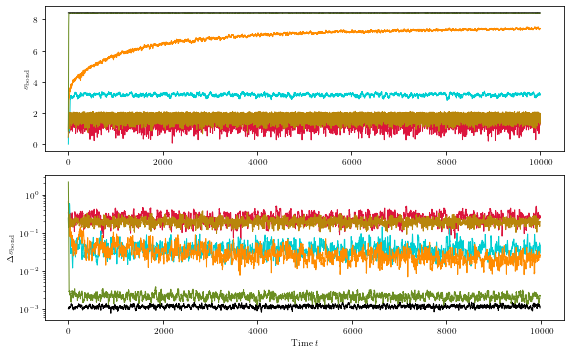

In [92]:
bond_entropy_timeseries(Qs, ICs, Rs, order=2)

In [93]:
def bond_entropy_distribution(QS, ICs, Rs, Li=-1, t0=1, axs=None, order=2):
    tight_layout = False
    if axs is None:
        fig, axs = plt.subplots(2,1, figsize=(3,5))
        tight_layout = True
    RS = 0
    RDS = 0
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            if IC[0] == "P":
                RS += Q.get_measure(f"sbisect_{order}", save=True)[int(t0/Q.dt):-1:int(1/Q.dt)] / len(Rs)
                RDS +=  Q.get_measure(f"Dsbisect_{order}", save=True)[int(t0/Q.dt):-1:int(1/Q.dt)] / len(Rs)

            else:
                Svals = Q.get_measure(f"sbisect_{order}", save=True)[int(t0/Q.dt):]
                Svals = Svals[Svals>1e-14]
                bins, hist = np.histogram(
                            Svals, 
                            bins=100, density=True)
                
                mx = np.max(Svals)
                mn = np.min(Svals)
                hist, edges = np.histogram(Svals, density=True,
                    bins=np.logspace(np.log10(mn), np.log10(mx), 100))
                bins = edges[:-1] + np.diff(edges)/2
                mask = (hist*bins*Svals.size) > 75
                hist = hist[mask]
                bins = bins[mask]
                axs[0].plot(bins, hist, c=colors[R], marker="o", ls="none", ms=2)
                
                
                DSvals = Q.get_measure(f"Dsbisect_{order}", save=True)[int(t0/Q.dt):]
                bins, hist = np.histogram(
                            DSvals, 
                            bins=100, density=True)
                
                mx = np.max(DSvals)
                mn = np.min(DSvals)
                hist, edges = np.histogram(DSvals, density=True,
                    bins=np.logspace(np.log10(mn), np.log10(mx), 100))
                bins = edges[:-1] + np.diff(edges)/2
                mask = (hist*bins*Svals.size) > 75
                hist = hist[mask]
                bins = bins[mask]
                axs[1].plot(bins, hist, c=colors[R], marker="o", ls="none", ms=2)

                
                
    
    #axs[0].hist(RS, color="k", bins=100, density=True)
    #axs[0].set_ylabel(names[f"sbisect_{order}"])
    axs[0].set_yscale("log")
    axs[0].set_xscale("log")
    #axs[0].set_ylim([1e-1, 1e1])

    #axs[1].set_xscale("log")
    #axs[1].hist(RDS, color="k", bins=100, density=True)
    axs[1].set_yscale("log")
    axs[1].set_xscale("log")
    #axs[1].set_ylabel(names[f"Dsbisect_{order}"])
    #axs[1].set_xlabel(names["time"])
    
    
    if tight_layout:
        fig.tight_layout()

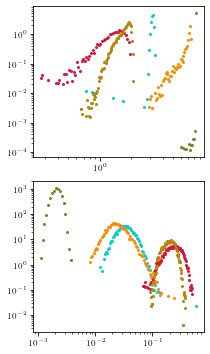

In [94]:
bond_entropy_distribution(Qs, ICs, Rs, order=2)

## Bond entropy L Scaling

In [10]:
def res(x, y, func):
    return np.array(y) - func(np.array(x))

In [11]:
def bond_entropy_Lscaling(QS, ICs, Rs, Ls, t0=5000, order=2, axs=None):
    tight_layout = False
    yticks = False
    if axs is None:
        fig, axs = plt.subplots(2,1, figsize=(4,6))
        tight_layout = True
        yticks = True
        
    RSbars = np.zeros(len(Ls))
    RDSbars = np.zeros(len(Ls))
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Sbars = []
            DSbars = []
            for Li, L in enumerate(Ls):
                Q = Qs[ICi, Ri, Li]
                S = Q.get_measure(f"sbisect_{order}", save=True)[int(t0/Q.dt)::int(1/Q.dt)]
                DS = Q.get_measure(f"Dsbisect_{order}", save=True)[int(t0/Q.dt)::int(1/Q.dt)]
                Sbar = np.mean(S)
                DSbar = np.mean(DS)
                Sbars.append(Sbar)
                DSbars.append(DSbar)
                if IC[0] == "P":
                    RSbars[Li] += Sbar / len(Rs)
                    RDSbars[Li] += DSbar / len(Rs)
            if IC[0] != "P":

                axs[0].plot(Ls, np.array(Sbars), c=colors[R], marker="o", ms=3, lw=0)
                #axs[0].set_yscale("log")
                #axs[0].set_xscale("log")
                axs[0].set_ylabel(names["sbisect_2avg"])

                axs[1].plot(Ls, DSbars, c=colors[R], marker="o", ms=3, lw=0)
                axs[1].set_yscale("log")
                #axs[1].set_xscale("log")
                exp_func, m, b = exp_fit(Ls, DSbars)
                pow_func, m, b = powerlaw_fit(Ls, DSbars)
                print(R, "exp", np.sum(res(Ls, DSbars, exp_func)**2), "pow", np.sum(res(Ls, DSbars, pow_func)**2))
                
                #axs[1].plot(Ls, exp_func(np.array(Ls)), c=colors[R], lw=1)
                #axs[1].plot(Ls, pow_func(np.array(Ls)), c=colors[R], lw=1, ls="--")
                
                axs[1].set_ylabel(names["Dsbisect_2avg"])
                axs[1].set_xlabel(names["size"])

                
    axs[0].plot(Ls, RSbars, c="k", marker="o", ms=3, lw=0)
    axs[1].plot(Ls, RDSbars, c="k", marker="o",ms=3, lw=0)

    
    if not yticks:
        axs[0].set_yticklabels([])
        axs[1].set_yticklabels([])
    
    if tight_layout:
        plt.tight_layout()

6 exp 0.006477541737340881 pow 0.00740299609034663
1 exp 0.0003618141856470647 pow 0.0012511717859273917
14 exp 0.00046729198631595154 pow 0.0011227262514457847
4 exp 0.0009698669364185952 pow 0.0010148770655121978
26 exp 0.0025714770068024782 pow 0.014632219198098165


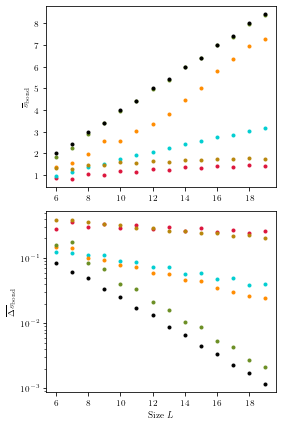

In [12]:
bond_entropy_Lscaling(Qs, ICs, Rs, Ls, order=2)

## Brody parameter time series

In [55]:
from figures import brody_fit
def get_ebisect(Q):
    if "ebisect" in Q.available_tasks:
        return Q.ebisect
    elif "espec" in Q.available_tasks:
        return Q.espec
    elif "ebipart" in Q.available_tasks:
        return Q.ebipart[int((Q.L-1)//2)]
    elif "bisect" in Q.available_tasks:
        return np.array([ms.spectrum(r) for r in Q.bisect])
    elif "bipart" in Q.avialable_tasks:
        return np.array(ms.spectrum(r) for r in Q.bipart[int((Q.L-1)//2)])
    else:
        print(Q.avilable_tasks)

def brody_parameter_timeseries(QS, ICs, Rs, Li=-1, axs=None):
    tight_layout = False
    yticks = False
    if axs is None:
        fig, ax = plt.subplots(1,1, figsize=(6,3))
        tight_layout = True
        yticks = True
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            etas = []
            detas = []
            if R not in (6,4):
                Q = Qs[ICi, Ri, Li]
                if IC[0] != "R":
                    especs = get_ebisect(Q)
                    for es0 in especs[11:]:
                        es0 = np.sort(es0)
                        es0 = es0[es0>1e-10]
                        es0 = es0[10:-10]
                        coeffs = np.polyfit(es0, np.arange(len(es0)), 10)
                        unrollf = np.poly1d(coeffs)
                        #unrollf, m, b = powerlaw_fit(es[1:], np.arange(len(es))[1:])
                        es = unrollf(es0)
                        es = np.sort(es)
                        #plt.plot(es)
                        #plt.show()
                        s = es[1:] - es[:-1]
                        s = s[s<7]
                        #s = s[s>1e-12]
                        hist, bin = np.histogram(s, density=True, bins=15)
                        x = bin[:-1] + np.diff(bin) / 2
                        xs = np.linspace(x[0], x[-1], 100)
                        func, popt, pcov = brody_fit(x, hist)
                        #plt.step(x, hist, where="mid")
                        #plt.plot(xs, func(xs))
                        #plt.show()
                        etas.append(popt[0])
                        detas.append(np.sqrt(np.diag(pcov)[0]))
                    print(Q.R)
                    etas = np.array(etas)
                    detas = np.array(detas)
                    #ax.plot(Q.ts[11:], etas)
                    mask = detas<1
                    detas = detas[mask]
                    etas = etas[mask]
                    ts = Q.ts[11:][mask]
                    aetas = Q.rolling(np.mean, etas)
                    ax.plot(ts[:1-int(L/Q.dt)], aetas, color=colors[R])
                    plt.show()
                    
            
                    
                

## Entanglement spectrum ratio statistics

In [13]:
zorders={6: 5, 4:2, 1:1, 14:3, 26:4}
def entanglement_spectrum_statistics(Qs, ICs, Rs, Li=-1, ax=None,
                        t0=5000, Npts=15,rmin=1e-2,rmax=100):
    logbins = np.logspace(np.log10(rmin), np.log10(rmax), Npts+1)
    if ax is None:
        fig, ax = plt.subplots(1,1)
        
    axins = ax.inset_axes([0.23, 0.17, 0.45, 0.4])

    Rrs = np.array([])
    for Ri, R in enumerate(Rs):
        logbins_shifted = logbins + zorders[R]*logbins/10
        for ICi, IC in enumerate(ICs):
            Q = Qs[ICi, Ri, Li]
            ess = Q.ebisect(save=True)
            rs = np.array([])
            for es in ess[int(t0/Q.dt):]:
                es = es[es>1e-14]
                es = np.sort(es)
                rs = np.r_[rs, (es[2:] - es[1:-1]) / ( es[1:-1] - es[:-2])]
            rs = rs[rs<rmax]
            rs = rs[rs>rmin]
            if IC[0] != "P":
                hist, bins = np.histogram(rs, density=True, bins=logbins)
                x = bins[:-1] + np.diff(bins) / 2
                mask = (hist*x*rs.size) > 75
                hist = hist[mask]
                x = x[mask]
                color = colors[R]
                for axi in (ax, axins):
                    axi.plot(x, hist, zorder=zorders[R],
                            marker='o', mec=color, 
                            mfc=colors[R], ms=1.6, ls="none")
                qg = (x+x*x) / (1+x+x*x)**(5/2) / (8/27)
                qp = 1/(1+x)**2
                Kp = ms.KL_divergence(hist/hist.sum(), qp/qp.sum())
                Kg = ms.KL_divergence(hist/hist.sum(), qg/qg.sum())
                
                print(f"R={R}, KP={round(Kp,5)}, KGOE={round(Kg,5)}")
            else:
                Rrs = np.r_[Rrs, rs]

    hist, bins = np.histogram(Rrs, density=True,
                             bins=logbins)
    
    x = bins[:-1] + np.diff(bins) / 2
    qg = (x+x*x)**2 / (1+x+x*x)**(4) / (4*np.pi/ (81 * np.sqrt(3)))
    Kg1 = ms.KL_divergence(hist/hist.sum(), qg/qg.sum())
    print(f"IC=R, KGUE={Kg1}")
    color = colors[R]
    x1 = np.geomspace(8e-2, 12, 20)
    x2 = np.geomspace(8e-2, 11, 20)
    x3 = np.geomspace(8e-2, 10, 20)
    for axi in (ax, axins):
        axi.plot(x, hist, marker="o", mec=colors["R"], 
            mfc=colors["R"], ms=2, ls="none")
        axi.plot(x1, 1/(1+x1)**2, c="crimson", ls="-", lw=1, 
                label="Poisson", zorder=100)
        axi.plot(x2, (x2+x2*x2) / (1+x2+x2*x2)**(5/2) / (8/27), 
                c="olivedrab", ls="--", lw=1, label="GOE", zorder=100)
        axi.plot(x3, (x3+x3*x3)**2 / (1+x3+x3*x3)**(4) / (4*np.pi/ (81 * np.sqrt(3))),
                c="k", ls="-.", lw=1, label="GUE", zorder=100)
        #ax.plot(x, (x+x*x)**4 / (1+x+x*x)**(7) / (4*np.pi/ (729 * np.sqrt(3))), 
        #        c="k", ls=":", label="GSE")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel("Gap ratio $r$")
    ax.set_ylabel("Prob. density $\mathcal{D}$")
    ax.minorticks_off()
    axins.set_ylim(0.1,0.75)
    axins.set_xlim(0.09,1.2)
    axins.set_xscale("log")
    axins.set_yticks([0.2, 0.4, 0.6])
    axins.set_xticks([0.1, 1])
    axins.tick_params(axis="both", which="both", direction="inout")
    ax.legend(frameon=False, 
              loc="lower left",
              bbox_to_anchor=(-0.22,0.95),
              bbox_transform=ax.transAxes,
              ncol=3,
              handletextpad=0.1,
              handlelength=1, 
              columnspacing=0.4)

R=6, KP=0.17575, KGOE=0.09459
R=1, KP=0.1908, KGOE=0.00729
R=14, KP=0.14953, KGOE=0.00033
R=4, KP=0.30691, KGOE=0.08721


KeyboardInterrupt: 

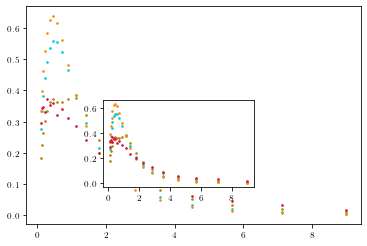

In [14]:
entanglement_spectrum_statistics(Qs, ICs, Rs, ax=None,
                        t0=500, Npts=20,rmin=1e-1, rmax=10)

In [58]:
"""R=6, KP=0.18811 KGOE=0.31662
R=1, KP=0.09538 KGOE=0.01553
R=14, KP=0.09094 KGOE=0.00076
R=4, KP=0.15089 KGOE=0.15915
R=26, KP=0.09233 KGOE=0.00028"""

'R=6, KP=0.18811 KGOE=0.31662\nR=1, KP=0.09538 KGOE=0.01553\nR=14, KP=0.09094 KGOE=0.00076\nR=4, KP=0.15089 KGOE=0.15915\nR=26, KP=0.09233 KGOE=0.00028'

## Page curves

In [ ]:
def page_curve(Qs, ICs, Rs, Li=-1, axs=None, t0=5000, ls="-", order=2):
    tight_layout=False
    if axs is None:
        fig, axs = plt.subplots(1,2)
        tight_layout=True
    Rpc = 0
    Rdpc = 0
    Rress = np.array([])
    for ICi, IC in enumerate(ICs):
        for Ri, R in enumerate(Rs):
            Q = Qs[ICi, Ri, Li]
            ells = np.arange(Q.L-1)
            pc = np.mean(Q.sbipart(order)[int(t0/Q.dt):], axis=0)
            dpc = np.std(Q.sbipart(order)[int(t0/Q.dt):], axis=0)
            if IC[0] != "P":
                axs[0].errorbar(ells, pc, yerr=dpc,
                            color=colors[R], 
                            ecolor=colors[R],
                            marker="o", ms=3, lw=1,
                            ls="none",)
                func, popt, pcov = page_fit(pc, dpc)
                axs[0].plot(ells, func(ells), c=colors[R], lw=1)
            
                    
            else:
                Rpc += pc/len(Rs)
                Rdpc += dpc/len(Rs)
           

            ress = np.array([])
            savgs = Q.sbipart(2)[int(t0/Q.dt)+1::int(1/Q.dt)].reshape(20, -1, Q.L-1)
            savgs = np.mean(savgs, axis=0)
            for savg in savgs:
                func, popt, pcov = page_fit(savg, None)
                res = np.abs(savg - func(ells))/savg
                if IC[0] != "P":
                    ress = np.r_[ress, res]
                else:
                    Rress = np.r_[Rress, res]
           
            if IC[0] != "P":
                p = np.linspace(1, 99, 100)
                axs[1].plot(p, 100*np.percentile(ress, p), lw=1, color=colors[R], ls=ls)
                print(f"L={L}, R={R}, med. res (%) = {round(100*np.percentile(ress, 50),3)}")
                
            #plt.imshow(S[:int(60/Q.dt)], extent=[0,Q.L,0,60], origin="lower")
            #plt.show()
    axs[0].errorbar(ells, Rpc, yerr=Rdpc, mec=colors["R"], ecolor=colors["R"],
                mfc="none", marker="x", ls="none", ms=3, lw=1)
    axs[0].set_ylabel(names["sbipart_2avg"])
    axs[0].set_xlabel(names["cut"])
    print(f"IC=R, med. res. (%) = {round(100*np.percentile(Rress, 50),4)}")
    axs[1].plot(p, 100*np.percentile(Rress, p), color=colors["R"])
    axs[1].set_yscale("log")
    axs[1].set_xlabel("Percentile")
    axs[1].set_ylabel(r"Residual $(\%)$")
    
    #axs[0].plot(ells, np.log2(ells+1)/100, c="k", ls="--")
    #mells = np.min(np.c_[ells+1, (Q.L)-(ells+1)], axis=1)
    #axs[0].plot(ells, np.log2(mells)/3,ls="--",c="k")
    #axs[0].plot(ells, mells-2.0**(2*mells-Q.L-1), ls="--",c="k")
    
    if tight_layout:
        plt.tight_layout()

L=19, R=6, med. res (%) = 3.446
L=19, R=1, med. res (%) = 1.235
L=19, R=14, med. res (%) = 2.583
L=19, R=4, med. res (%) = 34.351
L=19, R=26, med. res (%) = 0.056
IC=R, med. res. (%) = 0.001


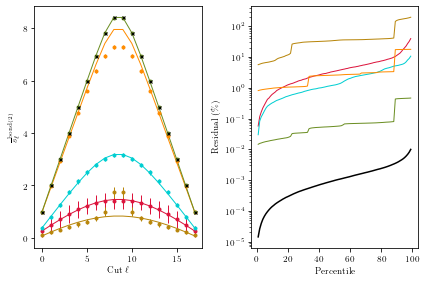

In [60]:
page_curve(Qs, ICs, Rs)

L=9, R=6, med. res (%) = 2.684
L=9, R=1, med. res (%) = 1.844
L=9, R=14, med. res (%) = 0.386
L=9, R=4, med. res (%) = 25.723
L=9, R=26, med. res (%) = 0.129
IC=R, med. res. (%) = 0.1235
L=18, R=6, med. res (%) = 3.261
L=18, R=1, med. res (%) = 1.402
L=18, R=14, med. res (%) = 2.334
L=18, R=4, med. res (%) = 33.97
L=18, R=26, med. res (%) = 0.053
IC=R, med. res. (%) = 0.0016


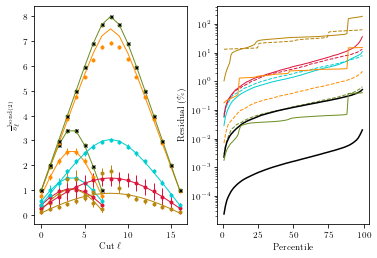

In [61]:
fig, axs = plt.subplots(1,2)
for L, ls in zip([9, 18], ["--", "-"]):
    page_curve(Qs, ICs, Rs, Li=Ls.index(L), axs=axs, ls=ls)

In [62]:
(2.634/2.817, 1.374/2.173, 1.746/0.498, 33.895/26.368, 0.052/0.17, 0.0018/0.104)

(0.9350372736954206,
 0.6323055683387023,
 3.5060240963855422,
 1.2854596480582525,
 0.30588235294117644,
 0.01730769230769231)

In [63]:
(13.149/12.644, 2.438/4.189, 1.75/1.843, 33.784/24.289, 0.05/0.578, 0.0064/0.455)

(1.0399398924391015,
 0.5820004774409168,
 0.9495387954422138,
 1.3909176993700851,
 0.08650519031141869,
 0.014065934065934066)

## QEB Lifetime

In [61]:
def qeb_lifetime(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    data = np.load(os.path.join(der, "qeb_decay/21-site_admix-processed.npy"), allow_pickle=True).item()
    keys = ["popts", "perrs", "errs", "ts", "ys_list"]
    popts, perrs, errs, ts, ys_list = [data[k] for k in keys]

    x = errs[2:]
    xs = np.linspace(x[0], x[-1], 100)
    y = popts[2:, 1]
    dy = perrs[2:, 1]
    func, m, b = powerlaw_fit(x, y)
    ax.errorbar(x, y, yerr=dy, 
                marker="o",
                ms=3,
                mec=colors[4], 
                ecolor=colors[4],
                mfc=colors[4],
                ls="none")
    ax.plot(xs, func(xs), color=colors[4], lw=1)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlabel(r"Admixture $\varepsilon~(\%)$")
    ax.set_ylabel(r"Lifetime $\tau$")
    ax.text(0.51,0.61, f"slope: \n{round(m,1)}", fontsize=9, transform=ax.transAxes)

    ax.minorticks_off()
    print(m)

-1.2883137526044046


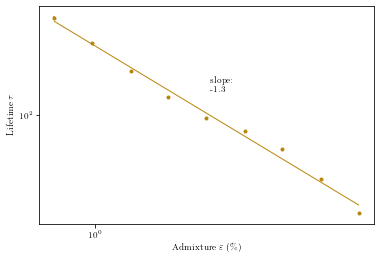

In [62]:
qeb_lifetime()

## Compiled Figure 4

6
1
14
4
26
L=19, R=6, med. res (%) = 1.747
L=19, R=1, med. res (%) = 1.114
L=19, R=14, med. res (%) = 1.973
L=19, R=4, med. res (%) = 34.46
L=19, R=26, med. res (%) = 0.055
IC=R, med. res. (%) = 0.001
16
R=6, KP=0.11828, KGOE=0.13224
20
R=1, KP=0.19324, KGOE=0.00723
20
R=14, KP=0.15398, KGOE=0.00035
20
R=4, KP=0.29151, KGOE=0.08312
20
R=26, KP=0.14787, KGOE=0.00032
IC=R, KGUE=0.000175686309951042
-1.2883137526044046


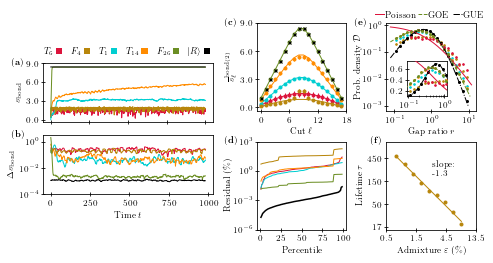

In [63]:


fig = plt.figure(figsize=(2*3.375, 3.5))

gs1 = GridSpec(2,1)
gs1.update(left=0.09, right=0.44, bottom=0.27, top=0.79,
           hspace=0.22)

gs2 = GridSpec(2, 2)
gs2.update(left=0.53, right=0.98, bottom=0.13, top=0.95, 
           hspace=0.35, wspace=0.45)

#gs2 = GridSpec(2, 2)
#gs2.update(left=0.53, right=0.97, bottom=0.55, top=0.95, 
#           wspace=0.6)

#gs3 = GridSpec(1, 2)
#gs3.update(left=0.57, right=0.97, bottom=0.13, top=0.45,
#           wspace=0.6)

timeseries_axs = [fig.add_subplot(gs1[0]), fig.add_subplot(gs1[1])]
pagecurve_axs = [fig.add_subplot(gs2[0,0]), fig.add_subplot(gs2[1,0])]
stats_ax = fig.add_subplot(gs2[0,1])
lifetime_ax = fig.add_subplot(gs2[1,1])


bond_entropy_timeseries(Qs, ICs, Rs, axs=timeseries_axs)
page_curve(Qs, ICs, Rs, axs=pagecurve_axs)
entanglement_spectrum_statistics(Qs, ICs, Rs, ax=stats_ax,
                                 t0=500, Npts=20,rmin=1e-1, rmax=10)
qeb_lifetime(ax=lifetime_ax)




timeticks = [0, 250, 500, 750, 1000]
cutticks = [0, 6, 12, 18]
percentileticks = [0, 25, 50, 75, 100]
ratioticks = [1e-1, 1e0, 1e1]
admixticks = [0.5, 1.5, 4.5, 13.5]


sbondticks = [0.0, 3.0, 6.0, 9.0]
Dsbondticks = [1e-4, 1e-2, 1e0]
residualticks = [1e-6, 1e-3, 1e-0, 1e3]
probticks = [1e-3, 1e-2, 1e-1, 1e0]
lifetimeticks = [17, 50, 150, 450]


timeseries_axs[0].set_yticks(sbondticks)
timeseries_axs[0].set_yticklabels([round(x,1) for x in sbondticks])
timeseries_axs[0].set_xticks(timeticks)
timeseries_axs[0].set_xticklabels([])
timeseries_axs[0].tick_params(axis="both", direction="inout")
timeseries_axs[1].set_xticks(timeticks)
timeseries_axs[1].set_yticks(Dsbondticks)
timeseries_axs[1].tick_params(axis="both", direction="inout")

pagecurve_axs[0].set_xticks(cutticks)
pagecurve_axs[0].set_yticks(sbondticks)
pagecurve_axs[0].set_yticklabels([round(x,1) for x in sbondticks])
pagecurve_axs[0].tick_params(axis="both", direction="inout")
pagecurve_axs[1].set_xticks(percentileticks)
pagecurve_axs[1].set_yticks(residualticks)
pagecurve_axs[1].yaxis.labelpad = -0.06
pagecurve_axs[1].tick_params(axis="both", direction="inout")
    
stats_ax.set_xticks(ratioticks) 
stats_ax.set_yticks(probticks)
stats_ax.yaxis.labelpad = 0.1
stats_ax.tick_params(axis="both", direction="inout")

lifetime_ax.set_xticks(admixticks)
lifetime_ax.set_yticks(lifetimeticks)
lifetime_ax.set_xticklabels(admixticks)
lifetime_ax.set_yticklabels(lifetimeticks)
lifetime_ax.set_ylim((15, 1000))
lifetime_ax.tick_params(axis="both", direction="inout")
    
    
lettering(timeseries_axs[0], -0.15, 1.0, 0)
lettering(timeseries_axs[1], -0.15, 1.0, 1)
lettering(pagecurve_axs[0], -0.3, 1.0, 2)
lettering(pagecurve_axs[1], -0.3, 1.0, 3)
lettering(stats_ax, -0.3, 1.0, 4)
lettering(lifetime_ax, -0.12, 1.0, 5)


legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in [6,4,1,14,26]]
legend_els.append(Patch(facecolor=colors["R"], edgecolor=None, label=names["R"]))

timeseries_axs[0].legend(handles=legend_els,
                        loc="lower left",
                        bbox_to_anchor=[-0.04, 0.98],
                        frameon=False,
                        markerfirst=False,
                        ncol=6,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)

plt.savefig("figures/figure4_V10.pdf")


6
1
14
4
26
6 exp 0.006477541737340881 pow 0.00740299609034663
1 exp 0.0003618141856470647 pow 0.0012511717859273917
14 exp 0.00046729198631595154 pow 0.0011227262514457847
4 exp 0.0009698669364185952 pow 0.0010148770655121978
26 exp 0.0025714770068024782 pow 0.014632219198098165


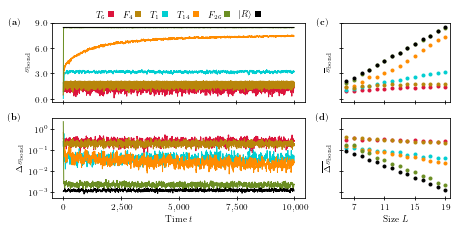

In [103]:
from matplotlib.ticker import FuncFormatter

fig = plt.figure(figsize=(2*3.375, 3.2))



gs = GridSpec(2, 3)
gs.update(left=0.14, right=0.96, bottom=0.14, top=0.9, wspace=0.33, hspace=0.2)

timeseries_axs = [fig.add_subplot(gs[0, 0:2]), fig.add_subplot(gs[1, 0:2])]
Lscaling_axs = [fig.add_subplot(gs[0,2]), fig.add_subplot(gs[1,2])]


bond_entropy_timeseries(Qs, ICs, Rs, axs=timeseries_axs)
bond_entropy_Lscaling(Qs, ICs, Rs, Ls, order=2, axs=Lscaling_axs)


timeticks = [0, 2500, 5000, 7500, 10000]
Lticks = [7, 11, 15, 19]

sbondticks = [0.0, 3.0, 6.0, 9.0]
Dsbondticks = [1e-3, 1e-2, 1e-1, 1e0]


timeseries_axs[0].set_yticks(sbondticks)
timeseries_axs[0].set_yticklabels([round(x,1) for x in sbondticks])
timeseries_axs[0].set_xticks(timeticks)
timeseries_axs[0].set_xticklabels([])
timeseries_axs[0].tick_params(axis="both", direction="inout")
timeseries_axs[1].set_xticks(timeticks)
timeseries_axs[1].set_yticks(Dsbondticks)
timeseries_axs[1].tick_params(axis="both", direction="inout")
timeseries_axs[1].get_xaxis().set_major_formatter(
    FuncFormatter(lambda x, p: format(int(x), ',')))

Lscaling_axs[0].set_yticks(sbondticks)
Lscaling_axs[0].set_yticklabels([])
Lscaling_axs[0].set_xticks(Lticks)
Lscaling_axs[0].set_xticklabels([])
Lscaling_axs[0].tick_params(axis="both", direction="inout")
Lscaling_axs[0].set_ylim(timeseries_axs[0].get_ylim())

Lscaling_axs[1].set_yticks(Dsbondticks)
Lscaling_axs[1].set_yticklabels([])
Lscaling_axs[1].set_xticks(Lticks)
Lscaling_axs[1].tick_params(axis="both", direction="inout")
Lscaling_axs[1].set_ylim(timeseries_axs[1].get_ylim())

    
lettering(timeseries_axs[0], -0.15, 1.0, 0) 
lettering(timeseries_axs[1], -0.15, 1.0, 1)
lettering(Lscaling_axs[0], -0.18, 1.0, 2)
lettering(Lscaling_axs[1], -0.18, 1.0, 3)



legend_els = [Patch(facecolor=colors[R], edgecolor=None, label=names[R]) for R in [6,4,1,14,26]]
legend_els.append(Patch(facecolor=colors["R"], edgecolor=None, label=names["R"]))

timeseries_axs[0].legend(handles=legend_els,
                        loc="center",
                        bbox_to_anchor=[0.5, 1.1],
                        frameon=False,
                        markerfirst=False,
                        ncol=6,
                        columnspacing=1,
                        handletextpad=0.3,
                        handlelength=0.7)

plt.savefig("figures/figure4_V12.pdf")